In [ ]:
import torch as th
import torch.nn as nn
import matplotlib.pyplot as plt

from pprint import pprint
from Algorithms.sac import config

# 0. Plot Setting

In [ ]:
import seaborn as sb
import matplotlib

sb.set_style('whitegrid')

FONTSIZE = 10
matplotlib.rcParams["figure.figsize"] = (10, 5)
matplotlib.rcParams["figure.dpi"] = 100
matplotlib.rcParams["figure.titlesize"] = FONTSIZE
matplotlib.rcParams["legend.fontsize"] = FONTSIZE
matplotlib.rcParams["xtick.labelsize"] = FONTSIZE
matplotlib.rcParams["ytick.labelsize"] = FONTSIZE
matplotlib.rcParams["axes.labelsize"] = FONTSIZE
matplotlib.rcParams["axes.titlesize"] = FONTSIZE
matplotlib.rcParams["savefig.bbox"] = "tight"
matplotlib.rcParams["savefig.pad_inches"] = 0.1
matplotlib.rcParams["lines.linewidth"] = 2
matplotlib.rcParams["axes.linewidth"] = 1.6

# 1. Model Setting

## 1.1 Load Config

In [ ]:
env_kwargs, model_kwargs, learn_kwargs = config.load_config('tmp_config.yaml')

In [ ]:
ntb_mode = False

model_kwargs.update({
    'buffer_size': 300,
    'learning_starts': 300,
    'batch_size': 15,
    'std_coeff': 0.06,
    'target_entropy' : -600.0,
    # 'ent_coef': "auto_0.8",

})

model_kwargs['policy_kwargs'].update({
    'ntb_mode': ntb_mode,

})

learn_kwargs.update({
    'total_timesteps': 2500

})

actor_net_kwargs = {'bn_kwargs': {'num_features': env_kwargs['n_assets']}}
critic_net_kwargs = {'bn_kwargs': {'num_features': env_kwargs['n_assets']}}

if ntb_mode:

    model_kwargs['policy_kwargs'].update({
        'net_arch': {'pi': [(nn.BatchNorm1d, 'bn'), 32, 32],
                     'qf': [(nn.BatchNorm1d, 'bn'), 2]},
        'actor_net_kwargs': actor_net_kwargs,
        'critic_net_kwargs': critic_net_kwargs,
    })

    model_kwargs['policy_kwargs']['features_extractor_kwargs'].update({
        'features_out': 64,
        'net_arch': [32]
    })

else:
    model_kwargs['policy_kwargs'].update({
        'net_arch': {'pi': [(nn.BatchNorm1d, 'bn'), 32, 32],
                     'qf': [(nn.BatchNorm1d, 'bn'), 2]},
        'actor_net_kwargs': actor_net_kwargs,
        'critic_net_kwargs': critic_net_kwargs,
    })

    model_kwargs['policy_kwargs']['features_extractor_kwargs'].update({
        'features_out': 64,
        'net_arch': [32]
    })

In [ ]:
config.reconstruct_config(env_kwargs, model_kwargs, learn_kwargs)

In [ ]:
pprint(env_kwargs)

In [ ]:
pprint(model_kwargs)

In [ ]:
pprint(learn_kwargs)

## 1.2 Make env, model

In [51]:
from Algorithms.sac import SAC
# from Algorithms.ddpg.double_ddpg import DDPG

model = SAC(**model_kwargs)

Using cuda device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.


In [52]:
model.policy

SACPolicy(
  (actor): CustomActor(
    (features_extractor): MarketObsExtractor(
      (layers): Sequential(
        (0): BatchNorm1d(1000, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (1): Linear(in_features=4, out_features=32, bias=True)
        (2): ReLU()
        (3): BatchNorm1d(1000, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (4): Linear(in_features=32, out_features=64, bias=True)
        (5): ReLU()
      )
    )
    (latent_pi): Sequential(
      (0): BatchNorm1d(1000, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (1): Linear(in_features=64, out_features=32, bias=True)
      (2): ReLU()
      (3): Linear(in_features=32, out_features=32, bias=True)
    )
    (mu): Sequential(
      (0): Linear(in_features=32, out_features=1, bias=True)
    )
    (log_std): Sequential(
      (0): Linear(in_features=32, out_features=1, bias=True)
    )
    (flatten): Flatten(start_dim=-2, end_dim=-1)
    (tanh): Tanh()

# 2. Learning

In [53]:
model = model.learn(**learn_kwargs)

Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
Logging to ../logs/tb_logs\sac_220609-1736_1
[Training Start]
Eval num_timesteps=30, episode_reward=-0.02 +/- 0.00
Episode length: 29.00 +/- 0.00
---------------------------------
| eval/              |          |
|    mean_ep_length  | 29       |
|    mean_reward     | -0.0216  |
| time/              |          |
|    total timesteps | 30       |
---------------------------------
New best mean reward!
Eval num_timesteps=60, episode_reward=-0.02 +/- 0.00
Episode length: 29.00 +/- 0.00
---------------------------------
| eval/              |          |
|    mean_ep_length  | 29       |
|    mean_reward     | -0.0222  |
| time/              |          |
|    total timesteps | 60       |
---------------------------------
Eval num_timesteps=90, episode_reward=-0.02 +/- 0.00
Episode length: 29.00 +/- 0.00
---------------------------------
| eval/              |          |
|    mean_ep_length  | 29       |
|    mean

In [12]:
config.save_config(f'{learn_kwargs["eval_log_path"]}/config.yaml', env_kwargs, model_kwargs, learn_kwargs)

<BSMarketEval instance> will be save as name. env_kwargs not in kwargs!
<BSMarketEval instance> will be save as name. eval_env_kwargs not in kwargs!
<Algorithms.sac.callbacks.ReportCallbacks object at 0x000001955601FE20> will be save as name. callback_kwargs not in kwargs!
../logs/tb_logs/sac_220609-1724_1/config.yaml was saved.


# 3. P&L Evaluation

In [28]:
# model = model.load('../logs/tb_logs/ddpg_220607-2214_stable'+'/best_model')
# model = model.load('../logs/tb_logs/ddpg_220607-2124_ntb_delta'+'/best_model')
# model = model.load('../logs/tb_logs/ddpg_220608-2037_1'+'/best_model')
model = model.load('../logs/tb_logs/sac_220609-1655_1'+'/best_model')
# model = model.load(learn_kwargs['eval_log_path'] + '/best_model')
# print(learn_kwargs['eval_log_path'] + '/best_model')

In [29]:
eval_env = learn_kwargs['eval_env']
# from Env.env import BSMarketEval
# eval_env = BSMarketEval(**env_kwargs)

In [1]:
import numpy as np

# random_pnl = np.mean([eval_env.pnl_eval() for _ in range(30)], axis=0)
# delta_pnl = np.mean([eval_env.delta_eval() for _ in range(30)], axis=0)
# rl_pnl = np.mean([eval_env.pnl_eval(model) for _ in range(30)], axis=0)

# random_pnl = np.load('best_results/random_pnl.npy')
# delta_pnl = np.load('../ddpg/best_results/delta_pnl.npy')
# rl_pnl = np.load('../ddpg/best_results/rl_pnl.npy')
# ntb_pnl_best = np.load('best_results/ntb_pnl.npy')

In [15]:
# np.save('best_results/random_pnl', random_pnl)
# np.save('best_results/delta_pnl', delta_pnl)
# np.save('best_results/rl_pnl', rl_pnl)

In [31]:
ntb_pnl = np.mean([eval_env.pnl_eval(model) for _ in range(30)], axis=0)

In [32]:
import numpy as np

def pnl_reward(pnl):
    mean = np.mean(pnl)
    std = np.std(pnl)
    return mean - 0.02 * std , (mean, std)

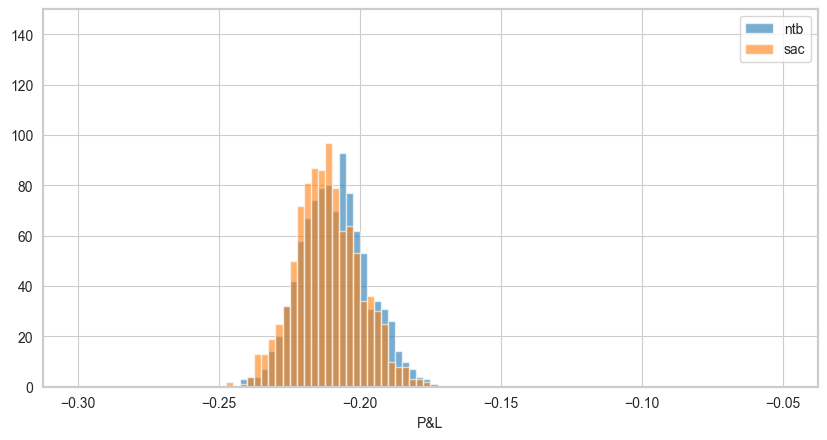

delta:		-0.2094, -0.2091, 0.0119
ntb_pnl:	-0.2117, -0.2115, 0.0116
rl:			-0.0002, -0.0000, 0.0060
-0.0023613764262449266
0.21157502845007328


In [35]:
plt.xlabel('P&L')
# plt.hist(random_pnl, bins=100, range=(-0.25, 0.05), alpha=0.6, label='random')
# plt.hist(random_pnl, bins=100, range=(-0.1, 0.05), alpha=0.6, label='random')
# plt.hist(delta_pnl, bins=100, range=(-0.1, 0.05), alpha=0.6, label='delta')
plt.hist(delta_pnl, bins=100, range=(-0.1, 0.05), alpha=0.6, label='delta')
plt.hist(ntb_pnl, bins=100, range=(-0.1, 0.05), alpha=0.6, label='ntb')
# plt.hist(rl_pnl, bins=100, range=(-0.1, 0.05), alpha=0.6, label='rl')
plt.ylim(0, 150)
plt.legend()
plt.show()

r1, (m1, s1) = pnl_reward(ntb_pnl_best)
r2, (m2, s2) = pnl_reward(ntb_pnl)
# r3, (m3, s3) = pnl_reward(rl_pnl)
print(f'delta:\t\t{r1:.4f}, {m1:.4f}, {s1:.4f}')
print(f'ntb_pnl:\t{r2:.4f}, {m2:.4f}, {s2:.4f}')
print(f'rl:\t\t\t{r3:.4f}, {m3:.4f}, {s3:.4f}')
print((r2-r1))
print((r3-r2))

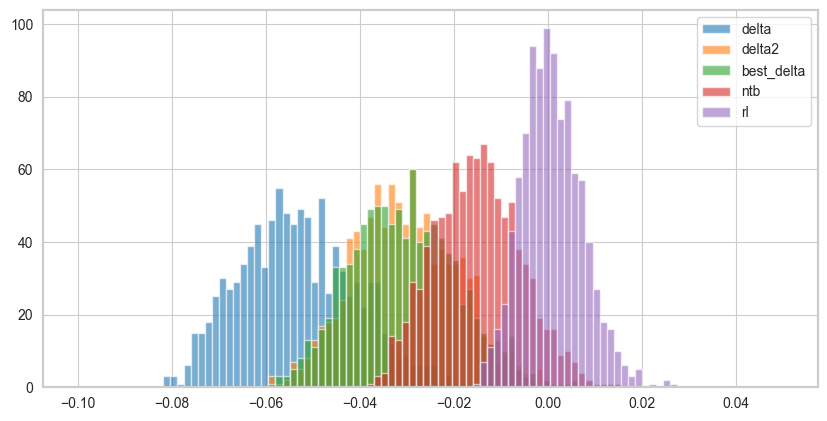

In [17]:
plt.hist(delta_pnl, bins=100, range=(-0.1, 0.05), alpha=0.6, label='delta')
plt.hist(np.mean([eval_env.delta_eval2() for _ in range(30)], axis=0), bins=100, range=(-0.1, 0.05), alpha=0.6, label='delta2')
plt.hist(np.load('best_results/delta_pnl.npy'), bins=100, range=(-0.1, 0.05), alpha=0.6, label='best_delta')
plt.hist(ntb_pnl, bins=100, range=(-0.1, 0.05), alpha=0.6, label='ntb')
plt.hist(rl_pnl, bins=100, range=(-0.1, 0.05), alpha=0.6, label='rl')
plt.legend()
plt.show()

In [2]:
delta_pnl = np.load('../ddpg/best_results/delta_pnl.npy')
ddpg_pnl = np.load('../ddpg/best_results/rl_pnl.npy')
ddpg_ntb_pnl = np.load('../ddpg/best_results//ntb_pnl.npy')
sac_ntb_pnl = np.load('best_results/ntb_pnl.npy')
sac_pnl = np.load('best_results/sac_pnl.npy')

In [7]:
delta_pnl.std()

0.01135903044001691

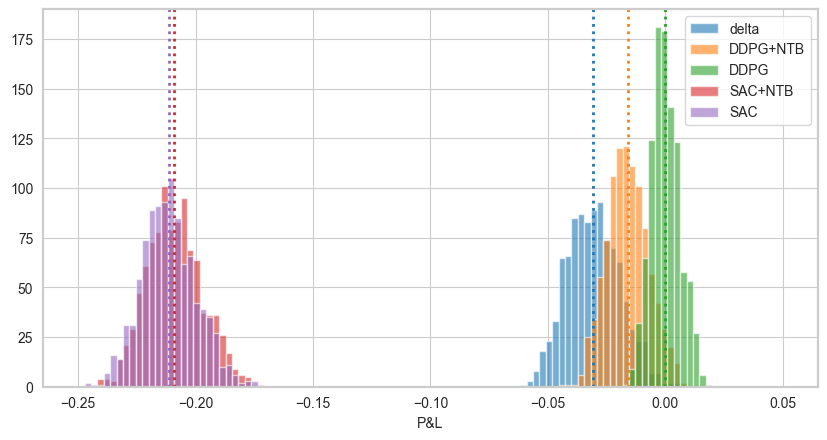

In [13]:
plt.xlabel('P&L')
plot_range = (-0.25, 0.05)
bins = 110

plt.hist(delta_pnl, bins=bins, range=plot_range, alpha=0.6, label='delta')
plt.axvline(delta_pnl.mean(), ls=':', lw=2, c='C0')

plt.hist(ddpg_ntb_pnl, bins=bins, range=plot_range, alpha=0.6, label='DDPG+NTB')
plt.axvline(ddpg_ntb_pnl.mean(), ls=':', lw=2, c='C1')

plt.hist(ddpg_pnl, bins=bins, range=plot_range, alpha=0.6, label='DDPG')
plt.axvline(ddpg_pnl.mean(), ls=':', lw=2, c='C2')

plt.hist(sac_ntb_pnl, bins=bins, range=plot_range, alpha=0.6, label='SAC+NTB')
plt.axvline(sac_ntb_pnl.mean(), ls=':', lw=2, c='C3')

plt.hist(sac_pnl, bins=bins, range=plot_range, alpha=0.6, label='SAC')
plt.axvline(sac_pnl.mean(), ls=':', lw=2, c='C4')

plt.legend()
plt.show()

In [18]:
def r1(pnl):
    return pnl.mean()/pnl.std()

def performance_print(pnl, name):
    print(f'{name}:\t{"" if len(name)>5 else "    "}{pnl.mean():.4f}\t{pnl.std():.4f}\t\t{r1(pnl):.4f}')

# print(f'delta:\t\t{delta_pnl.mean():.4f}\t{delta_pnl.std():.4f}\t\t{r1(delta_pnl):.4f}')
# print(f'ddpg+ntb:\t{ddpg_ntb_pnl.mean():.4f}\t{ddpg_ntb_pnl.std():.4f}\t\t{r1(ddpg_ntb_pnl)}')
# print(f'ddpg:\t\t{ddpg_pnl.mean():.4f}\t{ddpg_pnl.std():.4f}')
# print(f'sac+ntb:\t{sac_ntb_pnl.mean():.4f}\t{sac_ntb_pnl.std():.4f}')
# print(f'sac:\t\t{sac_pnl.mean():.4f}\t{sac_pnl.std():.4f}')

performance_print(delta_pnl, 'delta')
performance_print(ddpg_ntb_pnl, 'ddpg_ntb')
performance_print(ddpg_pnl, 'ddpg')
performance_print(sac_ntb_pnl, 'sac_ntb')
performance_print(sac_pnl, 'sac')

delta:	    -0.0307	0.0114		-2.6984
ddpg_ntb:	-0.0161	0.0089		-1.8122
ddpg:	    -0.0000	0.0060		-0.0055
sac_ntb:	-0.2091	0.0119		-17.6009
sac:	    -0.2115	0.0116		-18.2100


In [22]:
import pandas as pd
def performance_print(pnl, name):
    return [name, round(pnl.mean(), 4), round(pnl.std(), 4), round(r1(pnl), 4)]

df = pd.DataFrame([performance_print(delta_pnl, 'delta'),
                   performance_print(ddpg_ntb_pnl, 'ddpg_ntb'),
                   performance_print(ddpg_pnl, 'ddpg'),
                   performance_print(sac_ntb_pnl, 'sac_ntb'),
                   performance_print(sac_pnl, 'sac')],
                  columns=['name', 'mean', 'std', 'sharpe ratio'])

In [23]:
df

,name,mean,std,sharpe ratio
0,delta,-0.0307,0.0114,-2.6984
1,ddpg_ntb,-0.0161,0.0089,-1.8122
2,ddpg,-0.0000,0.0060,-0.0055
3,sac_ntb,-0.2091,0.0119,-17.6009
4,sac,-0.2115,0.0116,-18.2100
